In [32]:
import sys
import os
sys.path.append(os.path.abspath('../')) # Point to project root

In [67]:


import importlib
import modules.trainer
import modules.utils
import modules.callbacks
import modules.env
import env.custom_halfcheetah

# Force reload of the modules you changed
importlib.reload(modules.env)
importlib.reload(modules.callbacks)
importlib.reload(modules.utils)
importlib.reload(modules.trainer)
importlib.reload(env.custom_halfcheetah)

# Re-import the specific functions into the global namespace
from modules.trainer import train_agent
from modules.utils import *
from env.custom_halfcheetah import *

print("Modules reloaded successfully!")

Modules reloaded successfully!


In [68]:
from modules.trainer import train_agent
from modules.utils import *
from env.custom_halfcheetah import *

In [35]:


HALF_CHEETAH_CONFIG_UDR = config = {
    'env_id': 'CustomHalfCheetah-source-v0',
    'algorithm': 'SAC',
    'seed': 42,
    'timesteps': 1_000_000,
    'n_envs': 4,
    'vectorize': True,
    'normalize': True, 
    'lr': 3*1e-4,
    
    # DORAEMON Settings
    'use_doraemon': False,    

}

print("=== Training HalfCheetah with UDR ===")
model_udr, env_udr, _ = train_agent(HALF_CHEETAH_CONFIG_UDR, log_dir="./logs/halfcheetah/udr")


=== Training HalfCheetah with UDR ===
--- STARTING NEW TRAINING ---
Using cpu device
--- UDR Mode: Training without DORAEMON ---
Logging to ./tensorboard_logs/SAC_26
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.03e+03 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 190      |
|    time_elapsed    | 20       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -23.3    |
|    critic_loss     | 0.888    |
|    ent_coef        | 0.748    |
|    ent_coef_loss   | -2.84    |
|    learning_rate   | 0.0003   |
|    n_updates       | 974      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.01e+03 |
| time/              |          |
|    episodes        | 8        |
|    fps             | 202      |
|    time_elapsed 

In [71]:
# --- TEST SOURCE ---
source_raw = gym.make('CustomHalfCheetah-source-v0')
m_source = source_raw.unwrapped.model.body_mass[1]
print(f"VERIFICA DIRETTA - Massa Source: {m_source:.4f}")

# --- TEST TARGET ---
target_raw = gym.make('CustomHalfCheetah-target-v0')
m_target = target_raw.unwrapped.model.body_mass[1]
print(f"VERIFICA DIRETTA - Massa Target: {m_target:.4f}")

if m_source == m_target:
    print("❌ ERRORE CRITICO: Le masse sono identiche nel simulatore!")
else:
    print("✅ OK: Le masse sono differenziate.")

VERIFICA DIRETTA - Massa Source: 6.2502
VERIFICA DIRETTA - Massa Target: 7.7502
✅ OK: Le masse sono differenziate.


In [72]:
# Run evaluation
# Define the raw environments
# # from stable_baselines3 import SAC

norm_path = f"./logs/halfcheetah/udr/final_vecnormalize.pkl"
source_env = gym.make('CustomHalfCheetah-source-v0')

target_env = gym.make('CustomHalfCheetah-target-v0')
model_udr_loaded = SAC.load('C:\\Users\\irene\\OneDrive - Politecnico di Torino\\02_robot_learning\\project\\project-extension-bartolini_benvenuti\\results\\halfcheetah\\udr\\final_model.zip', device="cpu")
evaluate_sim2real(model_udr_loaded, source_env, target_env, log_dir="C:\\Users\\irene\\OneDrive - Politecnico di Torino\\02_robot_learning\\project\\project-extension-bartolini_benvenuti\\results\\halfcheetah\\udr", model_name="final")

Loaded Normalization stats from C:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\project-extension-bartolini_benvenuti\results\halfcheetah\udr/final_vecnormalize.pkl

--- Evaluating on SOURCE Env (Simulation) ---
Reward: 7857.84 +/- 43.83
Length: 1000.00 +/- 0.00 steps

--- Evaluating on TARGET Env (Real/Shifted) ---
Reward: 7971.22 +/- 39.36
Length: 1000.00 +/- 0.00 steps


(np.float64(7857.844417778402), np.float64(7971.223763019591))

In [ ]:
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv
from stable_baselines3 import SAC
#test su 500 timesteps non su 1000->  CustomHalfCheetah-source-v0 ha max_episode_steps=1000. CustomHalfCheetah-shift-v0 (usato per lo shift) ha max_episode_steps=500.
# 1. Crea l'ambiente con render_mode
raw_render_env = gym.make('CustomHalfCheetah-v0', render_mode='human')

# 2. Avvolgilo (NECESSARIO per caricare le statistiche)
render_env = DummyVecEnv([lambda: raw_render_env])

# 3. Carica le statistiche di normalizzazione del training
stats_path = './logs/halfcheetah/udr/final_vecnormalize.pkl'
render_env = VecNormalize.load(stats_path, render_env)

# IMPORTANTE: non aggiornare le medie durante il rendering!
render_env.training = False
render_env.norm_reward = False 

# 4. Carica il modello passandogli l'ambiente normalizzato
model_udr_loaded = SAC.load('./logs/halfcheetah/udr/final_model', env=render_env)

# Run a few episodes
n_episodes = 5
for episode in range(n_episodes):
    obs = render_env.reset() # VecEnv reset ritorna solo obs
    done = [False] # VecEnv lavora con liste di segnali
    total_reward = 0
    
    while not done[0]:
        action, _states = model_udr_loaded.predict(obs, deterministic=True)
        # VecEnv step ritorna (obs, rewards, dones, infos)
        obs, rewards, dones, infos = render_env.step(action)
        
        total_reward += rewards[0]
        done = dones
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")

render_env.close()

Episode 1: Total Reward = 7848.26


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


Episode 2: Total Reward = 7905.89
Episode 3: Total Reward = 7878.00
Episode 4: Total Reward = 7797.11
Episode 5: Total Reward = 7870.74


Caricamento modello da: C:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\project-extension-bartolini_benvenuti\results\halfcheetah\udr\final_model.zip
Environment 'CustomHalfCheetah-shift-v0' registrato correttamente.

Avvio valutazione robustezza su 9 configurazioni...
------------------------------------------------------------

[DEBUG] Shift richiesto: -5.0 kg | MASSA REALE: 1.2502 kg
Shift -5.0 kg | Reward:  3146.80 +/-  98.94

[DEBUG] Shift richiesto: -3.0 kg | MASSA REALE: 3.2502 kg
Shift -3.0 kg | Reward:  3512.86 +/-  42.25

[DEBUG] Shift richiesto: -2.0 kg | MASSA REALE: 4.2502 kg
Shift -2.0 kg | Reward:  3637.80 +/-  49.13

[DEBUG] Shift richiesto: -1.0 kg | MASSA REALE: 5.2502 kg
Shift -1.0 kg | Reward:  3724.81 +/-  35.69

[DEBUG] Shift richiesto: +0.0 kg | MASSA REALE: 6.2502 kg
Shift +0.0 kg | Reward:  3801.93 +/-  35.02

[DEBUG] Shift richiesto: +1.0 kg | MASSA REALE: 7.2502 kg
Shift +1.0 kg | Reward:  3840.14 +/-  31.26

[DEBUG] Shift richiesto:

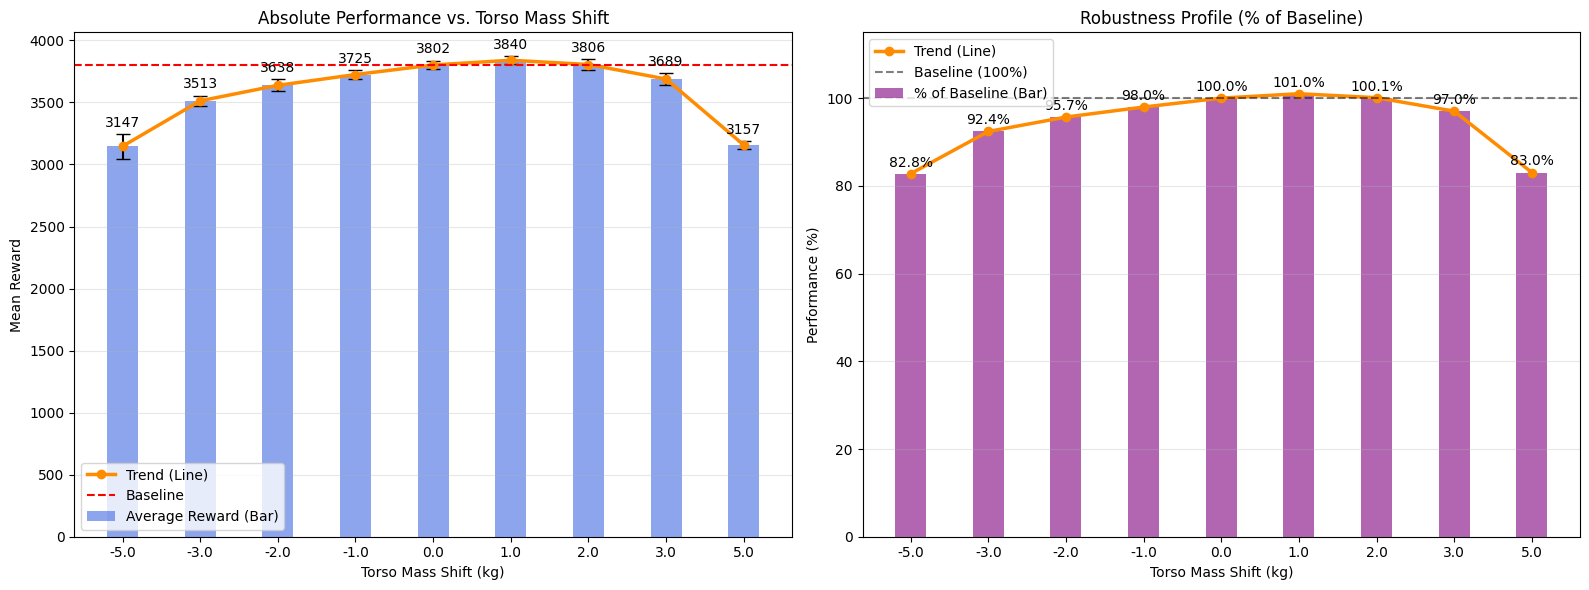

In [86]:
#test su 500 timesteps non su 1000->  CustomHalfCheetah-source-v0 ha max_episode_steps=1000. CustomHalfCheetah-shift-v0 (usato per lo shift) ha max_episode_steps=500.
# ECCO PERCHE' STATISTICHE NON CORRISPONDONO

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import os

# --- 1. CONFIGURAZIONE PATH ---
# Definisci i path una volta sola all'inizio
BASE_RESULTS_PATH = "C:\\Users\\irene\\OneDrive - Politecnico di Torino\\02_robot_learning\\project\\project-extension-bartolini_benvenuti\\results\\halfcheetah\\udr"
model_path = os.path.join(BASE_RESULTS_PATH, "final_model.zip")
norm_path = os.path.join(BASE_RESULTS_PATH, "final_vecnormalize.pkl")

# --- 2. CARICAMENTO MODELLO ---
print(f"Caricamento modello da: {model_path}")
model = SAC.load(model_path, device="cpu")

# --- 3. REGISTRAZIONE ENVIRONMENT ---
try:
    register(
        id="CustomHalfCheetah-shift-v0",
        entry_point=CustomHalfCheetah, 
        max_episode_steps=500,  # PORTATO A 1000 per coerenza
        kwargs={"domain": "shift", "mass_shift": 0.0}
    )
    print("Environment 'CustomHalfCheetah-shift-v0' registrato correttamente.")
except:
    pass

# --- 4. CONFIGURAZIONE VALUTAZIONE ---
mass_shifts = [-5.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 5.0]
n_eval_episodes = 20
results_mean = []
results_std = []

print(f"\nAvvio valutazione robustezza su {len(mass_shifts)} configurazioni...")
print("-" * 60)

# --- 5. LOOP DI VALUTAZIONE ---
for shift in mass_shifts:
    # Creazione ambiente base con lo shift specifico
    raw_env = gym.make("CustomHalfCheetah-shift-v0", mass_shift=shift)
    
    # Debug immediato della massa reale
    actual_mass = raw_env.unwrapped.model.body_mass[1]
    
    # Vettorizzazione (necessaria per VecNormalize)
    env = DummyVecEnv([lambda: raw_env])
    
    # CARICAMENTO UNICO DELLA NORMALIZZAZIONE
    if os.path.exists(norm_path):
        env = VecNormalize.load(norm_path, env)
        env.training = False      
        env.norm_obs = True     # <--- FONDAMENTALE per non avere reward a 600
        env.norm_reward = False 
    else:
        print(f"ATTENZIONE: Statistiche non trovate in {norm_path}")

    print(f"\n[DEBUG] Shift richiesto: {shift:+.1f} kg | MASSA REALE: {actual_mass:.4f} kg")

    # Valutazione
    episode_rewards, _ = evaluate_policy(
        model, 
        env, 
        n_eval_episodes=n_eval_episodes, 
        deterministic=True, 
        return_episode_rewards=True
    )
    
    mean_r = np.mean(episode_rewards)
    std_r = np.std(episode_rewards)
    results_mean.append(mean_r)
    results_std.append(std_r)
    
    print(f"Shift {shift:+.1f} kg | Reward: {mean_r:8.2f} +/- {std_r:6.2f}")
    
    env.close()

# --- 6. PREPARAZIONE DATI PER PLOT ---
results_mean = np.array(results_mean)
results_std = np.array(results_std)
if 0.0 in mass_shifts:
    baseline_idx = mass_shifts.index(0.0)
    baseline_reward = results_mean[baseline_idx]
else:
    baseline_reward = np.max(results_mean)

percentages = (results_mean / baseline_reward) * 100

# Creazione Grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.4
x_pos = np.arange(len(mass_shifts))

# --- Grafico A: Performance Assoluta ---
# 1. Le Barre
bars1 = ax1.bar(x_pos, results_mean, yerr=results_std, align='center', 
               alpha=0.6, ecolor='black', capsize=5, width=bar_width, 
               color='royalblue', label='Average Reward (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax1.plot(x_pos, results_mean, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax1.axhline(y=baseline_reward, color='red', linestyle='--', linewidth=1.5, label='Baseline')
ax1.set_title('Absolute Performance vs. Torso Mass Shift')
ax1.set_xlabel('Torso Mass Shift (kg)')
ax1.set_ylabel('Mean Reward')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(mass_shifts)
ax1.grid(True, axis='y', alpha=0.3)
ax1.legend()

# Etichette barre
ax1.bar_label(bars1, fmt='%.0f', padding=3)


# --- Grafico B: Performance Relativa ---
# 1. Le Barre
bars2 = ax2.bar(x_pos, percentages, align='center', 
                alpha=0.6, width=bar_width, 
                color='purple', label='% of Baseline (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax2.plot(x_pos, percentages, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax2.axhline(y=100.0, color='black', linestyle='--', alpha=0.5, label='Baseline (100%)')
ax2.set_title('Robustness Profile (% of Baseline)')
ax2.set_xlabel('Torso Mass Shift (kg)')
ax2.set_ylabel('Performance (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(mass_shifts)
ax2.set_ylim(0, max(115, np.max(percentages) + 10)) 
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend()

# Etichette barre
ax2.bar_label(bars2, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

In [ ]:

HALF_CHEETAH_CONFIG_DORAEMON = {
    "env_id": "CustomHalfCheetah-v0",
    "algorithm": "SAC",         # o "PPO"
    'seed': 42,
    'timesteps': 1_000_000,
    'n_envs': 4,
    'vectorize': True,
    'normalize': True, 
    'lr': 3*1e-4,

    # DORAEMON Settings
    'use_doraemon': True,  
    'threshold_reward': 3800,   # Adjust based on the task
}

model_doraemon, env_doraemon, _ = train_agent(HALF_CHEETAH_CONFIG_DORAEMON, log_dir="./logs/halfcheetah/doraemon")

--- STARTING NEW TRAINING ---
Using cpu device
Logging to ./tensorboard_logs/SAC_23
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 969      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 94       |
|    time_elapsed    | 42       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -23.1    |
|    critic_loss     | 0.881    |
|    ent_coef        | 0.748    |
|    ent_coef_loss   | -2.85    |
|    learning_rate   | 0.0003   |
|    n_updates       | 974      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 997      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 108      |
|    time_elapsed    | 73       |
|    total_timesteps | 8000     |
| train/             |          

In [76]:
# --- TEST SOURCE ---
source_raw = gym.make('CustomHalfCheetah-source-v0')
m_source = source_raw.unwrapped.model.body_mass[1]
print(f"VERIFICA DIRETTA - Massa Source: {m_source:.4f}")

# --- TEST TARGET ---
target_raw = gym.make('CustomHalfCheetah-target-v0')
m_target = target_raw.unwrapped.model.body_mass[1]
print(f"VERIFICA DIRETTA - Massa Target: {m_target:.4f}")

if m_source == m_target:
    print("❌ ERRORE CRITICO: Le masse sono identiche nel simulatore!")
else:
    print("✅ OK: Le masse sono differenziate.")

VERIFICA DIRETTA - Massa Source: 6.2502
VERIFICA DIRETTA - Massa Target: 7.7502
✅ OK: Le masse sono differenziate.


In [77]:
# Run evaluation
# Define the raw environments
source_env = gym.make('CustomHalfCheetah-source-v0')
target_env = gym.make('CustomHalfCheetah-target-v0')

evaluate_sim2real(model_doraemon, source_env, target_env, log_dir="./logs/halfcheetah/doraemon", model_name="final")

Loaded Normalization stats from ./logs/halfcheetah/doraemon/final_vecnormalize.pkl

--- Evaluating on SOURCE Env (Simulation) ---
Reward: 6098.04 +/- 105.33
Length: 1000.00 +/- 0.00 steps

--- Evaluating on TARGET Env (Real/Shifted) ---
Reward: 6208.18 +/- 91.81
Length: 1000.00 +/- 0.00 steps


(np.float64(6098.037110718598), np.float64(6208.179302798584))

In [ ]:
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv

# 1. Crea l'ambiente con render_mode
raw_render_env = gym.make('CustomHalfCheetah-v0', render_mode='human')

# 2. Avvolgilo (NECESSARIO per caricare le statistiche)
render_env = DummyVecEnv([lambda: raw_render_env])

# 3. Carica le statistiche di normalizzazione del training
stats_path = './logs/halfcheetah/doraemon/final_vecnormalize.pkl'
render_env = VecNormalize.load(stats_path, render_env)

# IMPORTANTE: non aggiornare le medie durante il rendering!
render_env.training = False
render_env.norm_reward = False 

# 4. Carica il modello passandogli l'ambiente normalizzato
model_doraemon_loaded = SAC.load('./logs/halfcheetah/doraemon/final_model', env=render_env)

# Run a few episodes
n_episodes = 5
for episode in range(n_episodes):
    obs = render_env.reset() # VecEnv reset ritorna solo obs
    done = [False] # VecEnv lavora con liste di segnali
    total_reward = 0
    
    while not done[0]:
        action, _states = model_doraemon_loaded.predict(obs, deterministic=True)
        # VecEnv step ritorna (obs, rewards, dones, infos)
        obs, rewards, dones, infos = render_env.step(action)
        
        total_reward += rewards[0]
        done = dones
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")

render_env.close()

Episode 1: Total Reward = 6055.45
Episode 2: Total Reward = 5985.13
Episode 3: Total Reward = 6193.54
Episode 4: Total Reward = 6105.29
Episode 5: Total Reward = 6118.62


Caricamento modello da .\logs\halfcheetah\doraemon\final_model.zip...
Environment 'CustomHalfCheetah-shift-v0' registrato.

Avvio valutazione su 9 configurazioni...
------------------------------------------------------------
[DEBUG] Shift: -5.0 kg | MASSA REALE: 1.2502 kg
-> Reward:  2479.93 +/-  96.88
[DEBUG] Shift: -3.0 kg | MASSA REALE: 3.2502 kg
-> Reward:  2795.63 +/-  43.41
[DEBUG] Shift: -2.0 kg | MASSA REALE: 4.2502 kg
-> Reward:  2832.42 +/-  49.72
[DEBUG] Shift: -1.0 kg | MASSA REALE: 5.2502 kg
-> Reward:  2845.16 +/-  73.97
[DEBUG] Shift: +0.0 kg | MASSA REALE: 6.2502 kg
-> Reward:  2953.38 +/-  66.79
[DEBUG] Shift: +1.0 kg | MASSA REALE: 7.2502 kg
-> Reward:  3011.91 +/-  43.27
[DEBUG] Shift: +2.0 kg | MASSA REALE: 8.2502 kg
-> Reward:  3022.18 +/-  76.80
[DEBUG] Shift: +3.0 kg | MASSA REALE: 9.2502 kg
-> Reward:  2941.25 +/-  81.00
[DEBUG] Shift: +5.0 kg | MASSA REALE: 11.2502 kg
-> Reward:  2668.58 +/- 144.37


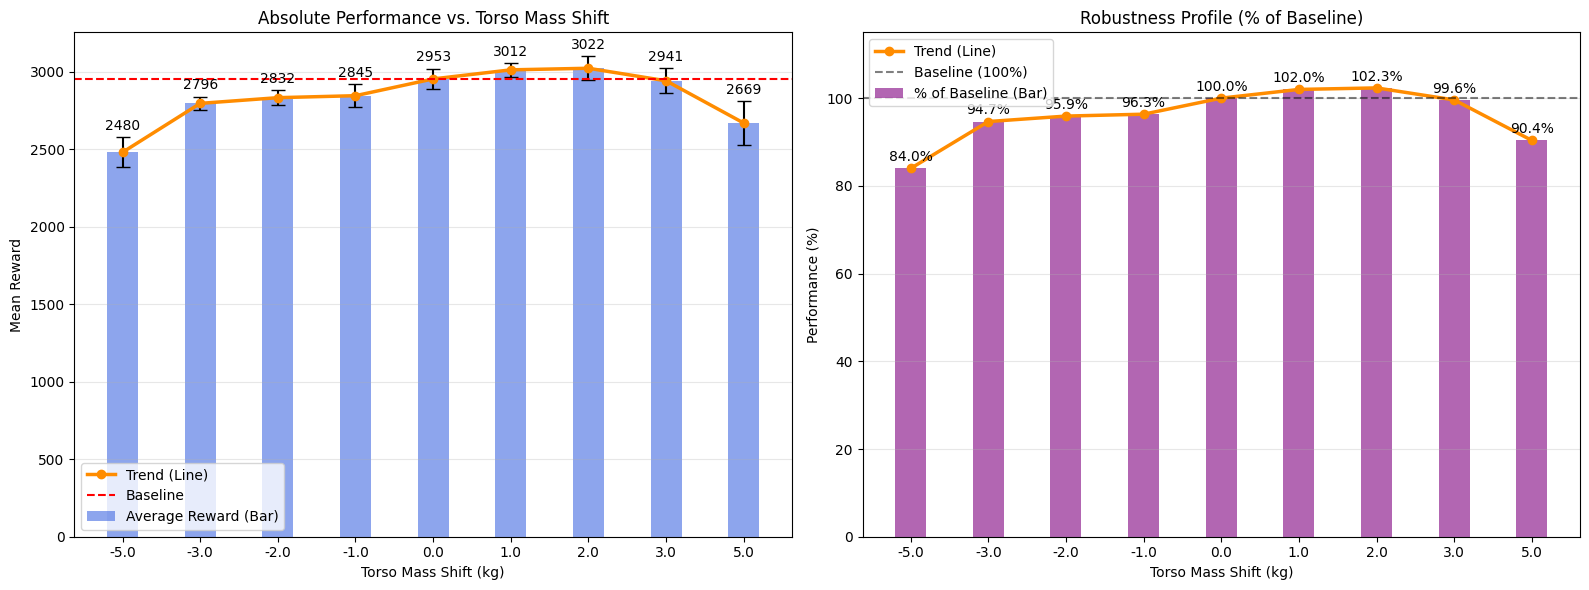

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import os

# --- 1. CONFIGURAZIONE PATH E CARICAMENTO ---
# Usa path consistenti
base_path = ".\\logs\\halfcheetah\\doraemon"
model_path = os.path.join(base_path, "final_model.zip")
norm_path = os.path.join(base_path, "final_vecnormalize.pkl")

print(f"Caricamento modello da {model_path}...")
model = SAC.load(model_path, device="cpu")

# --- 2. REGISTRAZIONE ENVIRONMENT ---
try:
    register(
        id="CustomHalfCheetah-shift-v0",
        entry_point=CustomHalfCheetah, 
        max_episode_steps=500, # Allineato a SOURCE/TARGET
        kwargs={"domain": "shift", "mass_shift": 0.0}
    )
    print("Environment 'CustomHalfCheetah-shift-v0' registrato.")
except:
    pass

# --- 3. CONFIGURAZIONE VALUTAZIONE ---
mass_shifts = [-5.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 5.0]
n_eval_episodes = 10 # Ridotto per velocità, aumenta se serve precisione
results_mean = []
results_std = []

print(f"\nAvvio valutazione su {len(mass_shifts)} configurazioni...")
print("-" * 60)

# --- 4. LOOP DI VALUTAZIONE ---
for shift in mass_shifts:
    # Creazione ambiente base
    raw_env = gym.make("CustomHalfCheetah-shift-v0", mass_shift=shift)
    
    # Debug massa (PRIMA dei wrapper per sicurezza)
    actual_mass = raw_env.unwrapped.model.body_mass[1]
    
    # Applicazione Wrapper Vettoriale
    env = DummyVecEnv([lambda: raw_env])
    
    # Caricamento Normalizzazione
    if os.path.exists(norm_path):
        env = VecNormalize.load(norm_path, env)
        env.training = False      
        env.norm_obs = True    # FONDAMENTALE: Attiva la normalizzazione input
        env.norm_reward = False # Non serve normalizzare il reward in eval
    else:
        print(f"ATTENZIONE: Statistiche non trovate in {norm_path}")

    print(f"[DEBUG] Shift: {shift:+.1f} kg | MASSA REALE: {actual_mass:.4f} kg")

    # Valutazione
    episode_rewards, _ = evaluate_policy(
        model, 
        env, 
        n_eval_episodes=n_eval_episodes, 
        deterministic=True, 
        return_episode_rewards=True
    )
    
    mean_r = np.mean(episode_rewards)
    std_r = np.std(episode_rewards)
    results_mean.append(mean_r)
    results_std.append(std_r)
    
    print(f"-> Reward: {mean_r:8.2f} +/- {std_r:6.2f}")
    env.close()

# --- 5. PLOTTING ---
# (Il tuo codice di plotting va bene, assicurati solo che results_mean sia np.array)
results_mean = np.array(results_mean)
results_std = np.array(results_std)

# ... resto del tuo codice di plotting ...

if 0.0 in mass_shifts:
    baseline_idx = mass_shifts.index(0.0)
    baseline_reward = results_mean[baseline_idx]
else:
    baseline_reward = np.max(results_mean)

percentages = (results_mean / baseline_reward) * 100

# Creazione Grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.4
x_pos = np.arange(len(mass_shifts))

# --- Grafico A: Performance Assoluta ---
# 1. Le Barre
bars1 = ax1.bar(x_pos, results_mean, yerr=results_std, align='center', 
               alpha=0.6, ecolor='black', capsize=5, width=bar_width, 
               color='royalblue', label='Average Reward (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax1.plot(x_pos, results_mean, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax1.axhline(y=baseline_reward, color='red', linestyle='--', linewidth=1.5, label='Baseline')
ax1.set_title('Absolute Performance vs. Torso Mass Shift')
ax1.set_xlabel('Torso Mass Shift (kg)')
ax1.set_ylabel('Mean Reward')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(mass_shifts)
ax1.grid(True, axis='y', alpha=0.3)
ax1.legend()

# Etichette barre
ax1.bar_label(bars1, fmt='%.0f', padding=3)


# --- Grafico B: Performance Relativa ---
# 1. Le Barre
bars2 = ax2.bar(x_pos, percentages, align='center', 
                alpha=0.6, width=bar_width, 
                color='purple', label='% of Baseline (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax2.plot(x_pos, percentages, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax2.axhline(y=100.0, color='black', linestyle='--', alpha=0.5, label='Baseline (100%)')
ax2.set_title('Robustness Profile (% of Baseline)')
ax2.set_xlabel('Torso Mass Shift (kg)')
ax2.set_ylabel('Performance (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(mass_shifts)
ax2.set_ylim(0, max(115, np.max(percentages) + 10)) 
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend()

# Etichette barre
ax2.bar_label(bars2, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()